# Class 6: Advanced `pandas`

Currently, `pandas`' `Series` and `DataFrame` might seem to us as no more than tables with complicated indexing methods. In this lesson, we will learn more about what makes `pandas` so powerful and how we can use it to write efficient and readable code.

````{note}
Some of the features described below only work with pandas >= 1.0.0. Make sure you have the latest pandas installation when running this notebook. To check the version of your pandas (or any other package), import it and print its `__version__` attribute:
```python
>>> import pandas as pd
>>> print(pd.__version__)
'1.2.0'
```
````

## Missing Data

<div style="text-align:center"><img src="https://static.wikia.nocookie.net/lostpedia/images/1/16/Lost-season1.jpg/revision/latest/scale-to-width-down/300?cb=20070303221754" /></div>

The last question in the previous class pointed us to [working with missing data](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html). But how and why do missing data occur?

One option is pandas' index alignment, the property that makes sure that each value will have the same index throughout the entire computation process.

In [10]:
import pandas as pd
import numpy as np


A = pd.Series([2, 4, 6], index=[0, 1, 2])
B = pd.Series([1, 3, 5], index=[1, 2, 3])
A + B

0    NaN
1    5.0
2    9.0
3    NaN
dtype: float64

The NaNs we have are what we call missing data, and this is how they are represented in pandas. We'll discuss that in more detail in a few moments.

The same thing occurs with DataFrames:

In [11]:
A = pd.DataFrame(np.random.randint(0, 20, (2, 2)),
                 columns=list('AB'))
A

,A,B
0,6,11
1,9,5


In [12]:
B = pd.DataFrame(np.random.randint(0, 10, (3, 3)),
                 columns=list('BAC'))
B

,B,A,C
0,6,8,1
1,2,8,1
2,8,3,7


In [13]:
new = A + B
print(new)
print(f"\nReturned dtypes:\n{new.dtypes}")

      A     B   C
0  14.0  17.0 NaN
1  17.0   7.0 NaN
2   NaN   NaN NaN

Returned dtypes:
A    float64
B    float64
C    float64
dtype: object


```{note}
Note how `new.dtypes` itself returns a `Series` of dtypes, with it's own `object` dtype.
```

The dataframe's shape is the shape of the larger dataframe, and the "extra" row (index 2) was filled with NaNs. Since we have NaNs, the data type of the column is implicitly converted to a floating point type. To have integer dataframes with NaNs, we have to explicitly say we want them available. More on that later.

Another way to introduce missing data is through reindexing. If we "resample" our data we can achieve the following:

In [14]:
df = pd.DataFrame(np.random.randn(5, 3), index=['a', 'c', 'e', 'f', 'h'],
                  columns=['one', 'two', 'three'])
df

,one,two,three
a,1.222374,0.941036,0.380220
c,-0.950380,1.359308,1.245010
e,-0.038110,0.323388,0.881577
f,0.706950,-0.555918,-0.000683
h,1.451893,-1.816021,0.791840


In [15]:
df2 = df.reindex(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
df2

,one,two,three
a,1.222374,0.941036,0.380220
b,NaN,NaN,NaN
c,-0.950380,1.359308,1.245010
d,NaN,NaN,NaN
e,-0.038110,0.323388,0.881577
f,0.706950,-0.555918,-0.000683
g,NaN,NaN,NaN
h,1.451893,-1.816021,0.791840


But what is `NaN`? Is it the same as `None`? To better answer the former, let's first have a closer look at the latter.

### The `None` object

`None` is the standard null value in Python, and is used extensively in normal usage of the language. For example, functions that don't have a `return` statement, implicitly return `None`. While `None` can be used as a missing data type, it's probably not the best choice.

In [16]:
vals1 = np.array([1, None, 3, 4])
vals1

array([1, None, 3, 4], dtype=object)

The `dtype` is `object`, because the best common type of `int`s and a `None` is a Python `object`. This slows down computation time on these arrays:

In [17]:
for dtype in ['object', 'int']:
    print("dtype =", dtype)
    %timeit np.arange(1E6, dtype=dtype).sum()
    print()

dtype = object
43.1 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

dtype = int
341 µs ± 1.47 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



If you recall from a couple of lessons ago, the performance of `object` arrays is very similar to that of standard lists (generally speaking, the two data structures are effectively identical).

Another thing we can't do is aggregation:

In [18]:
vals1.sum()

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

### The `NaN` value

`NaN` is a special floating-point value recognized by all programming languages that conform to the IEEE standard (which means most of them). As we mentioned before, it forces the entire array to have a floating point type:

In [19]:
vals2 = np.array([1, np.nan, 3, 4])
vals2.dtype

dtype('float64')

Creating floating point arrays is very fast, so performance isn't hindered. NaN is sometimes described as a "data virus", since it infects objects it touches:

In [20]:
1 + np.nan

nan

In [21]:
0 * np.nan

nan

In [22]:
vals2.sum(), vals2.min(), vals2.max()

(nan, nan, nan)

In [23]:
np.nan == np.nan

False

Numpy has `nan`-aware counterparts to many of its aggregation functions, which can work with NaNs correctly. They usually have the same name as their non-NaN sibling, but with the "nan" prefix:

In [24]:
print(np.nansum(vals2))
print(np.nanmean(vals2))

8.0
2.6666666666666665


However, pandas objects account for NaNs in their calculations, as we'll soon see.

Pandas can handle both `NaN` and `None` interchangeably:

In [25]:
ser = pd.Series([1, np.nan, 2, None])
ser

0    1.0
1    NaN
2    2.0
3    NaN
dtype: float64

### The `NaT` value


When dealing with datetime values or indices, the missing value is represented as `NaT`, or not-a-time:
<div style="text-align:center"><img src="https://149366099.v2.pressablecdn.com/wp-content/uploads/2014/10/What-is-time.png" /></div>

In [26]:
df['timestamp'] = pd.Timestamp('20180101')
df

,one,two,three,timestamp
a,1.222374,0.941036,0.380220,2018-01-01
c,-0.950380,1.359308,1.245010,2018-01-01
e,-0.038110,0.323388,0.881577,2018-01-01
f,0.706950,-0.555918,-0.000683,2018-01-01
h,1.451893,-1.816021,0.791840,2018-01-01


In [27]:
df2 = df.reindex(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
df2

,one,two,three,timestamp
a,1.222374,0.941036,0.380220,2018-01-01
b,NaN,NaN,NaN,NaT
c,-0.950380,1.359308,1.245010,2018-01-01
d,NaN,NaN,NaN,NaT
e,-0.038110,0.323388,0.881577,2018-01-01
f,0.706950,-0.555918,-0.000683,2018-01-01
g,NaN,NaN,NaN,NaT
h,1.451893,-1.816021,0.791840,2018-01-01


### Operations and calculations with missing data

In [28]:
a = pd.DataFrame(np.random.random((5, 2)), columns=['one', 'two'])
a.iloc[1, 1] = np.nan
a

,one,two
0,0.307007,0.608862
1,0.989388,NaN
2,0.068104,0.519292
3,0.881803,0.572062
4,0.176668,0.570929


In [29]:
b = pd.DataFrame(np.random.random((6, 3)), columns=['one', 'two', 'three'])
b.iloc[2, 2] = np.nan
b

,one,two,three
0,0.178986,0.382830,0.402055
1,0.194800,0.386910,0.853929
2,0.803260,0.155697,NaN
3,0.808805,0.532103,0.392492
4,0.111170,0.975744,0.667562
5,0.983706,0.310677,0.742454


In [30]:
a + b

,one,three,two
0,0.485993,NaN,0.991692
1,1.184189,NaN,NaN
2,0.871363,NaN,0.674988
3,1.690608,NaN,1.104164
4,0.287838,NaN,1.546673
5,NaN,NaN,NaN


As we see, missing values propagate naturally through these arithmetic operations. Statistics also works:

In [31]:
(a + b).describe()
# Summation - NaNs are zero.
# If everything is NaN - the result is NaN as well.
# pandas' cumsum and cumprod ignore NaNs but preserve them in the resulting arrays.

,one,three,two
count,5.000000,0.0,4.000000
mean,0.903998,NaN,1.079379
std,0.559622,NaN,0.360647
min,0.287838,NaN,0.674988
25%,0.485993,NaN,0.912516
50%,0.871363,NaN,1.047928
75%,1.184189,NaN,1.214791
max,1.690608,NaN,1.546673


We can also receive a boolean mask of the NaNs in a dataframe:

In [32]:
mask = (a + b).isnull()  # also isna(), and the opposite .notnull()
mask

,one,three,two
0,False,True,False
1,False,True,True
2,False,True,False
3,False,True,False
4,False,True,False
5,True,True,True


#### Filling missing values

The simplest option is to use the `fillna` method:

In [33]:
summed = a + b
summed.iloc[4, 0] = np.nan
summed

,one,three,two
0,0.485993,NaN,0.991692
1,1.184189,NaN,NaN
2,0.871363,NaN,0.674988
3,1.690608,NaN,1.104164
4,NaN,NaN,1.546673
5,NaN,NaN,NaN


In [34]:
summed.fillna(0)

,one,three,two
0,0.485993,0.0,0.991692
1,1.184189,0.0,0.000000
2,0.871363,0.0,0.674988
3,1.690608,0.0,1.104164
4,0.000000,0.0,1.546673
5,0.000000,0.0,0.000000


In [35]:
summed.fillna('missing')  # changed dtype to "object"

,one,three,two
0,0.485993,missing,0.991692
1,1.184189,missing,missing
2,0.871363,missing,0.674988
3,1.690608,missing,1.104164
4,missing,missing,1.546673
5,missing,missing,missing


In [36]:
summed.fillna(method='pad')  # The NaN column remained the same, but values were propagated forward
# We can also use the "backfill" method to fill in values to the back

/tmp/ipykernel_1151799/1540442133.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  summed.fillna(method='pad')  # The NaN column remained the same, but values were propagated forward


,one,three,two
0,0.485993,NaN,0.991692
1,1.184189,NaN,0.991692
2,0.871363,NaN,0.674988
3,1.690608,NaN,1.104164
4,1.690608,NaN,1.546673
5,1.690608,NaN,1.546673


In [37]:
summed.fillna(method='pad', limit=1)  # No more than one padded NaN in a row

/tmp/ipykernel_1151799/1451676853.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  summed.fillna(method='pad', limit=1)  # No more than one padded NaN in a row


,one,three,two
0,0.485993,NaN,0.991692
1,1.184189,NaN,0.991692
2,0.871363,NaN,0.674988
3,1.690608,NaN,1.104164
4,1.690608,NaN,1.546673
5,NaN,NaN,1.546673


In [38]:
summed.fillna(summed.mean())  # each column received its respective mean. The NaN column is untouched.

,one,three,two
0,0.485993,NaN,0.991692
1,1.184189,NaN,1.079379
2,0.871363,NaN,0.674988
3,1.690608,NaN,1.104164
4,1.058038,NaN,1.546673
5,1.058038,NaN,1.079379


#### Dropping missing values

We've already seen in the short exercise the `dropna` method, that allows us to drop missing values:

In [39]:
summed

,one,three,two
0,0.485993,NaN,0.991692
1,1.184189,NaN,NaN
2,0.871363,NaN,0.674988
3,1.690608,NaN,1.104164
4,NaN,NaN,1.546673
5,NaN,NaN,NaN


In [40]:
filled = summed.fillna(summed.mean())
filled

,one,three,two
0,0.485993,NaN,0.991692
1,1.184189,NaN,1.079379
2,0.871363,NaN,0.674988
3,1.690608,NaN,1.104164
4,1.058038,NaN,1.546673
5,1.058038,NaN,1.079379


In [41]:
filled.dropna(axis=1)  # each column containing NaN is dropped

,one,two
0,0.485993,0.991692
1,1.184189,1.079379
2,0.871363,0.674988
3,1.690608,1.104164
4,1.058038,1.546673
5,1.058038,1.079379


In [42]:
filled.dropna(axis=0)  # each row containing a NaN is dropped

,one,three,two


#### Interpolation

The last way to to fill in missing values is through [interpolation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html).

The default interpolation methods perform linear interpolation on the data, based on its ordinal index:

In [43]:
summed

,one,three,two
0,0.485993,NaN,0.991692
1,1.184189,NaN,NaN
2,0.871363,NaN,0.674988
3,1.690608,NaN,1.104164
4,NaN,NaN,1.546673
5,NaN,NaN,NaN


In [44]:
summed.interpolate()  # notice all the details in the interpolation of the three columns

,one,three,two
0,0.485993,NaN,0.991692
1,1.184189,NaN,0.833340
2,0.871363,NaN,0.674988
3,1.690608,NaN,1.104164
4,1.690608,NaN,1.546673
5,1.690608,NaN,1.546673


We can also interpolate with the actual index values in mind:

In [45]:
# Create "missing" index
timeindex = pd.Series(['1/1/2018', '1/4/2018', '1/5/2018', '1/7/2018', '1/8/2018'])
timeindex = pd.to_datetime(timeindex)
data_to_interp = [1, np.nan, 5, np.nan, 8]
df_to_interp = pd.DataFrame(data_to_interp, index=timeindex)
df_to_interp

,0
2018-01-01,1.0
2018-01-04,NaN
2018-01-05,5.0
2018-01-07,NaN
2018-01-08,8.0


In [46]:
df_to_interp.interpolate()  # the index values aren't taken into account

,0
2018-01-01,1.0
2018-01-04,3.0
2018-01-05,5.0
2018-01-07,6.5
2018-01-08,8.0


In [47]:
df_to_interp.interpolate(method='index')  # notice how the data obtains the "right" values

,0
2018-01-01,1.0
2018-01-04,4.0
2018-01-05,5.0
2018-01-07,7.0
2018-01-08,8.0


Pandas has many other interpolation methods, based on SciPy's. 

In [48]:
df_inter_2 = pd.DataFrame({'A': [1, 2.1, np.nan, 4.7, 5.6, 6.8],
                           'B': [.25, np.nan, np.nan, 4, 12.2, 14.4]})
df_inter_2

,A,B
0,1.0,0.25
1,2.1,NaN
2,NaN,NaN
3,4.7,4.00
4,5.6,12.20
5,6.8,14.40


In [49]:
df_inter_2.interpolate(method='polynomial', order=2)

,A,B
0,1.000000,0.250000
1,2.100000,-2.703846
2,3.451351,-1.453846
3,4.700000,4.000000
4,5.600000,12.200000
5,6.800000,14.400000


### Missing Values in Non-Float Columns

Starting from pandas v1.0.0 pandas gained support for NaN values in non-float columns. This feature is a bit experimental currently, so the default behavior still converts integers to floats for example, but the support is there if you know where to look. By default:

In [50]:
nanint = pd.Series([1, 2, np.nan, 4])
nanint  # the result has a dtype of float64 even though all numbers are integers.

0    1.0
1    2.0
2    NaN
3    4.0
dtype: float64

We can try to force pandas' hand here, but it won't work:

In [51]:
nanint = pd.Series([1, 2, np.nan, 4], dtype="int32")

ValueError: cannot convert float NaN to integer

To our rescue comes the new `pd.Int32Dtype`:

In [52]:
nanint = pd.Series([1, 2, np.nan, 4], dtype="Int32")
nanint

0       1
1       2
2    <NA>
3       4
dtype: Int32

It worked! We have a series with integers and a missing value! Notice the changes we had to made:
1. The `NaN` is `<NA>` now. It's actually a new type of `NaN` called `pd.NA`.
2. The data type had to be mentioned explictly, meaning that the conversion will work only if we know in advance that we'll have NA values.
3. The data type is `Int32`. It's CamelCase and it's actually a class underneath. Standard datatypes are lowercase.

Caveats aside, this is definitely useful for scientists who sometimes have integer values and do not want to convert them to float to supports NAs.

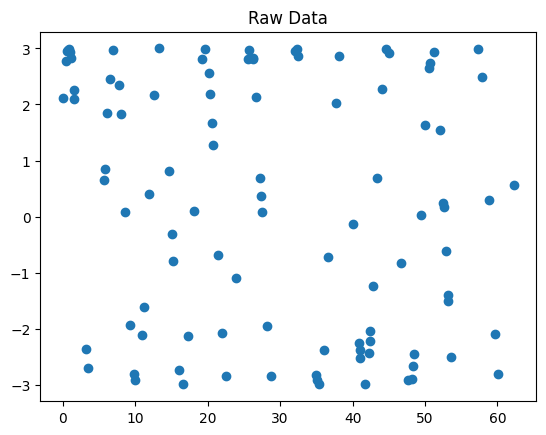

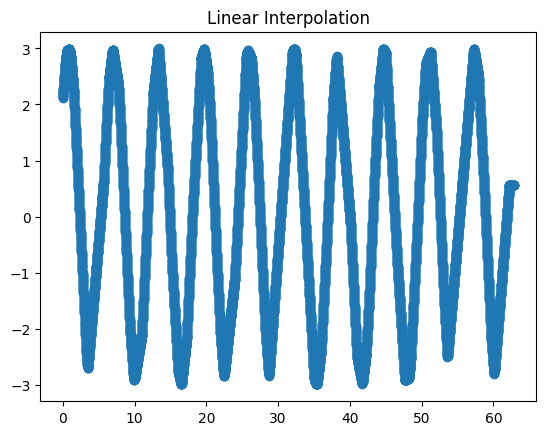

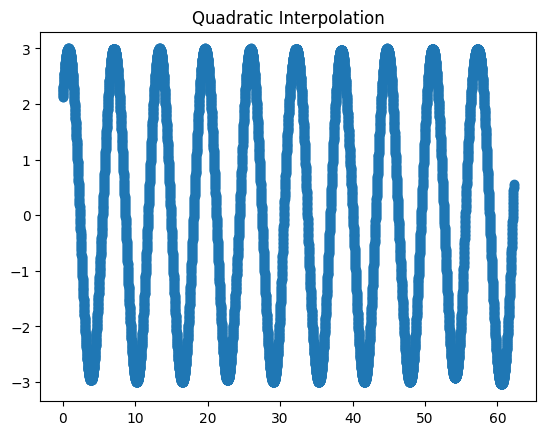

In [53]:
import matplotlib.pyplot as plt
from myst_nb import glue

n_cycles = 10
n_samples = 10000
amplitude = 3
phase = np.pi / 4
end = 2 * np.pi * n_cycles
x = np.linspace(0, end, num=n_samples)
y = amplitude * np.sin(x + phase)

chosen_idx = np.random.choice(n_samples, size=100, replace=False)
data = pd.DataFrame(np.nan, index=x, columns=['raw'])
data.iloc[chosen_idx, 0] = y[chosen_idx]

# plotting
fig1, ax1 = plt.subplots()
ax1.set_title('Raw Data')
data.raw.plot(marker='o', ax=ax1)
data['lin_inter'] = data.raw.interpolate(method='index')
fig2, ax2 = plt.subplots()
ax2.set_title('Linear Interpolation')
data.lin_inter.plot(marker='o', ax=ax2)
data['quad_inter'] = data.raw.interpolate(method='quadratic')
fig3, ax3 = plt.subplots()
ax3.set_title('Quadratic Interpolation')
data.quad_inter.plot(marker='o', ax=ax3)

glue("fig1", fig1, display=False)
glue("fig2", fig2, display=False)
glue("fig3", fig3, display=False)

`````{admonition} Exercise: Missing Data
* Create a vector of 10000 measurements from a 10-cycle sinus wave. Remember that a single period of sine starts at 0 and ends at 2$\pi$, so 10 periods span between 0 and 20$\pi$.
````{dropdown} Solution
```python
n_cycles = 10
n_samples = 10000
amplitude = 3
phase = np.pi / 4
end = 2 * np.pi * n_cycles
x = np.linspace(0, end, num=n_samples)
y = amplitude * np.sin(x + phase)
```
````
* Using `np.random.choice(replace=False)` sample 100 points from the wave and place them in a Series.
````{dropdown} Solution
```python
chosen_idx = np.random.choice(n_samples, size=100, replace=False)
data = pd.DataFrame(np.nan, index=x, columns=['raw'])
data.iloc[chosen_idx, 0] = y[chosen_idx]
```
````
* Plot the chosen points.
````{dropdown} Solution
```python
fig1, ax1 = plt.subplots()
ax1.set_title('Raw data pre-interpolation')
data.raw.plot(marker='o', ax=ax1)
```
```{glue:figure} fig1
    :figwidth: 500px
```
````
* Interpolate the points using linear interpolation and plot them on a different graph.
````{dropdown} Solution
```python
data['lin_inter'] = data.raw.interpolate(method='index')
fig2, ax2 = plt.subplots()
ax2.set_title('Linear interpolation')
data.lin_inter.plot(marker='o', ax=ax2)
```
```{glue:figure} fig2
    :figwidth: 500px
```
````
* Interpolate the points using quadratic interpolation and plot them on a different graph. 
````{dropdown} Solution
```python
data['quad_inter'] = data.raw.interpolate(method='quadratic')
fig3, ax3 = plt.subplots()
ax3.set_title('Quadratic interpolation')
data.quad_inter.plot(marker='o', ax=ax3)
```
```{glue:figure} fig3
    :figwidth: 500px
```
````
`````

## Categorical Data

So far, we've used examples with quantitative data. Let's now have a look at [categorical data](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html), i.e. data can only have one of a specific set, or categories, of values. For example, if we have a column which marks the weekday, then it can obviously only be one of seven options. Same for boolean data, colors, and other examples. These data columns should be marked as "categorical" to reduce memory consumption and improve performance. It also tells the code readers more about the nature of that data column.

The easiest way to create a categorical variable is to declare it as such, or to convert as existing column to a categorical data type:

In [54]:
s = pd.Series(["a", "b", "c", "a"], dtype="category")
s

0    a
1    b
2    c
3    a
dtype: category
Categories (3, object): ['a', 'b', 'c']

In [55]:
df = pd.DataFrame({"A": ["a", "b", "c", "a"]})
df["B"] = df["A"].astype("category")
print(f"DataFrame:\n{df}")
print(f"\nData types:\n{df.dtypes}")

DataFrame:
   A  B
0  a  a
1  b  b
2  c  c
3  a  a

Data types:
A      object
B    category
dtype: object


We can also force order between our categories, or force specific categories on our data, using the special CategoricalDtype (which we won't show).

As we said, memory usage is reduced when working with categorical data:

In [56]:
df_obj = pd.DataFrame({'a': np.random.random(10_000), 'b': ['a'] * 10_000})
df_obj

,a,b
0,0.066624,a
1,0.854047,a
2,0.544826,a
3,0.464085,a
4,0.405314,a
...,...,...
9995,0.823350,a
9996,0.744166,a
9997,0.059290,a
9998,0.256323,a


In [57]:
df_cat = pd.DataFrame({'a': df_obj['a'], 'b': df_obj['b'].astype('category')})
df_cat

,a,b
0,0.066624,a
1,0.854047,a
2,0.544826,a
3,0.464085,a
4,0.405314,a
...,...,...
9995,0.823350,a
9996,0.744166,a
9997,0.059290,a
9998,0.256323,a


In [58]:
df_obj.memory_usage()

Index      128
a        80000
b        80000
dtype: int64

In [59]:
df_cat.memory_usage()

Index      128
a        80000
b        10116
dtype: int64

A factor of 8 in memory reduction.

## Hierarchical Indexing

Last time we mentioned that while a DataFrame is inherently a 2D object, it can contain multi-dimensional data. The way a DataFrame (and a Series) does that is with [hierarchical indexing](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html), or sometimes Multi-Indexing.

### Simple Example: Temperature in a Grid

In this example, our data is the temperature sampled across a 2-dimensional grid. First, we need to generate the required set of indices, $(x, y)$, which point to a specific location inside the square. These coordinates can then be assigned the designated temperature values. A list of such coordinates can be a simple `Series`:

In [60]:
values = np.array([1.2, 0.8, 3.1, 0.1, 0.05, 1, 1.4, 2.1, 2.9])
coords = [('r0', 'c0'), ('r0', 'c1'), ('r0', 'c2'), 
          ('r1', 'c0'), ('r1', 'c1'), ('r1', 'c2'), 
          ('r2', 'c0'), ('r2', 'c1'), ('r2', 'c2')]  # r is row, c is column
points = pd.Series(values, index=coords, name='temperature')
points

(r0, c0)    1.20
(r0, c1)    0.80
(r0, c2)    3.10
(r1, c0)    0.10
(r1, c1)    0.05
(r1, c2)    1.00
(r2, c0)    1.40
(r2, c1)    2.10
(r2, c2)    2.90
Name: temperature, dtype: float64

It is important we understand that this is a series because _the data is one-dimensional_. The actual data is contained in that rightmost column, a one-dimensional array. We do have two coordinates for each point, but the data itself, the temperature, is one-dimensional.

Currently, the index is a simple tuple of coordinates. It's a single column, containing tuples. Pandas can help us to index this data in a more intuitive manner, using a MultiIndex object.

In [61]:
mindex = pd.MultiIndex.from_tuples(coords)
mindex

MultiIndex([('r0', 'c0'),
            ('r0', 'c1'),
            ('r0', 'c2'),
            ('r1', 'c0'),
            ('r1', 'c1'),
            ('r1', 'c2'),
            ('r2', 'c0'),
            ('r2', 'c1'),
            ('r2', 'c2')],
           )

We received something which looks quite similar to the list of tuples we had before, but it's a [`MultiIndex`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html) instance. Let's see how it helps us by `reindex`ing our data with it:

In [62]:
points = points.reindex(mindex)
points

r0  c0    1.20
    c1    0.80
    c2    3.10
r1  c0    0.10
    c1    0.05
    c2    1.00
r2  c0    1.40
    c1    2.10
    c2    2.90
Name: temperature, dtype: float64

This looks good. Each index level is represented by a column, with the data being the last one. The "missing" values indicate that the value in that cell is the same as the value above it.

You might have assumed that accessing the data now is much more intuitive. Let's look at the values of all the points in the first row, `r0`:

In [63]:
points.loc['r0', :]  # .loc() is label-based indexing

c0    1.2
c1    0.8
c2    3.1
Name: temperature, dtype: float64

Or the values of points in the second column:

In [64]:
points.loc[:, 'c1']

r0    0.80
r1    0.05
r2    2.10
Name: temperature, dtype: float64

In [65]:
points.loc[:, :]  # all values - each level of the index has its own colon (:)

r0  c0    1.20
    c1    0.80
    c2    3.10
r1  c0    0.10
    c1    0.05
    c2    1.00
r2  c0    1.40
    c1    2.10
    c2    2.90
Name: temperature, dtype: float64

Note that `.iloc` disregards the MultiIndex, treating our data as a simple one-dimensional vector (as it actually is):

In [66]:
points.iloc[6]
# points.iloc[0, 1]  # ERRORS

1.4

Besides making the syntax cleaner, these slicing operations are as efficient as their single-dimension counterparts.

It should be clear that a MultiIndex can have more than two levels. Modelling a 3D cube (with the temperatures inside it) is as easy as:

In [67]:
values3d = np.array([1.2, 0.8, 
                     3.1, 0.1, 
                     0.05, 1, 
                     1.4, 2.1, 
                     2.9, 0.3,
                     2.4, 1.9])
# 3D coordinates with a shape of (r, c, z) = (3, 2, 2)
coords3d = [('r0', 'c0', 'z0'), ('r0', 'c0', 'z1'), 
            ('r0', 'c1', 'z0'), ('r0', 'c1', 'z1'),
            ('r1', 'c0', 'z0'), ('r1', 'c0', 'z1'),
            ('r1', 'c1', 'z0'), ('r1', 'c1', 'z1'), 
            ('r2', 'c0', 'z0'), ('r2', 'c0', 'z1'),
            ('r2', 'c1', 'z0'), ('r2', 'c1', 'z1')]  # we'll soon see an easier way to create this index
cube = pd.Series(values3d, index=pd.MultiIndex.from_tuples(coords3d), name='temp_cube')
cube

r0  c0  z0    1.20
        z1    0.80
    c1  z0    3.10
        z1    0.10
r1  c0  z0    0.05
        z1    1.00
    c1  z0    1.40
        z1    2.10
r2  c0  z0    2.90
        z1    0.30
    c1  z0    2.40
        z1    1.90
Name: temp_cube, dtype: float64

We can even name the individual levels, which helps with some slicing operations we'll see below:

In [68]:
cube.index.names = ['x', 'y', 'z']
cube

x   y   z 
r0  c0  z0    1.20
        z1    0.80
    c1  z0    3.10
        z1    0.10
r1  c0  z0    0.05
        z1    1.00
    c1  z0    1.40
        z1    2.10
r2  c0  z0    2.90
        z1    0.30
    c1  z0    2.40
        z1    1.90
Name: temp_cube, dtype: float64

Again, you have to remember that this is one-dimensional data, with a three-dimensional index. In statistical term, we might term the indices a fixed, independent categorical variable, while the values are the dependent variable. Pandas actually has a [`CategoricalIndex`](https://pandas.pydata.org/docs/reference/api/pandas.CategoricalIndex.html) object which you'll meet in one of your future homework assignments (but don't be afraid to hit the link and check it out on your own if you just can't wait).

### More on extra dimensions

In the previous square example, it's very appealing to ditch the MultiIndex altogether and just work with a dataframe, or even a simple NumPy array. This is because the two indices represented rows and columns. A quick way to turn one representation into the other is the [`stack()`\\`unstack()`](https://pandas.pydata.org/docs/user_guide/reshaping.html) method:

In [69]:
points.index.names = ['rows', 'columns']
points

rows  columns
r0    c0         1.20
      c1         0.80
      c2         3.10
r1    c0         0.10
      c1         0.05
      c2         1.00
r2    c0         1.40
      c1         2.10
      c2         2.90
Name: temperature, dtype: float64

In [70]:
pts_df = points.unstack()
pts_df

columns,c0,c1,c2
rows,,,
r0,1.2,0.80,3.1
r1,0.1,0.05,1.0
r2,1.4,2.10,2.9


In [71]:
pts_df.stack()  # back to a series

rows  columns
r0    c0         1.20
      c1         0.80
      c2         3.10
r1    c0         0.10
      c1         0.05
      c2         1.00
r2    c0         1.40
      c1         2.10
      c2         2.90
dtype: float64

If we want to turn the indices into "real" columns, we can use the `reset_index()` method:

In [72]:
pts_df_reset = points.reset_index()
pts_df_reset

,rows,columns,temperature
0,r0,c0,1.20
1,r0,c1,0.80
2,r0,c2,3.10
3,r1,c0,0.10
4,r1,c1,0.05
5,r1,c2,1.00
6,r2,c0,1.40
7,r2,c1,2.10
8,r2,c2,2.90


So why bother with these (you haven't seen nothing yet) complicated multi-indices?

As you might have guessed, adding data points, i.e. increasing the dimensionality of the data, is very easy and intuitive. Data remains aligned through addition and deletion of data. Moreover, treating these categorical variables as an index can help the mental modeling of the problem, especially when you wish to perform statistical modeling with your analysis.

### Constructing a MultiIndex

Creating a hierarchical index can be done in several ways:

In [73]:
pd.MultiIndex.from_arrays([['a', 'a', 'b', 'b'], [1, 2, 1, 2]])

MultiIndex([('a', 1),
            ('a', 2),
            ('b', 1),
            ('b', 2)],
           )

In [74]:
pd.MultiIndex.from_tuples([('a', 1), ('a', 2), ('b', 1), ('b', 2)])

MultiIndex([('a', 1),
            ('a', 2),
            ('b', 1),
            ('b', 2)],
           )

In [75]:
pd.MultiIndex.from_product([['a', 'b'], [1, 2]])  # Cartesian product

MultiIndex([('a', 1),
            ('a', 2),
            ('b', 1),
            ('b', 2)],
           )

The most common way to construct a MultiIndex, though, is to add to the existing index one of the columns of the dataframe. We'll see how it's done below.

Another important note is that with dataframes, the column and row index is symmetric. In effect this means that  the columns could also contain a MultiIndex:

In [76]:
index = pd.MultiIndex.from_product([[2013, 2014], [1, 2]],
                                   names=['year', 'visit'])
columns = pd.MultiIndex.from_product([['Bob', 'Guido', 'Sue'], ['HR', 'Temp']],
                                     names=['subject', 'type'])

# mock some data
data = np.round(np.random.randn(4, 6), 1)
data[:, ::2] *= 10
data += 37

# create the DataFrame
health_data = pd.DataFrame(data, index=index, columns=columns)
health_data

subject      Bob       Guido         Sue      
type          HR  Temp    HR  Temp    HR  Temp
year visit                                    
2013 1      21.0  38.1  43.0  36.9  39.0  36.7
     2      18.0  39.1  28.0  38.5  30.0  36.5
2014 1      27.0  36.1  39.0  39.1  28.0  35.2
     2      46.0  37.9  27.0  37.2  50.0  36.7

This sometimes might seem too much, and so usually people prefer to keep the column index as a simple list of names, moving any nestedness to the row index. This is due to the fact that usually columns represent the measured dependent variable.

In [77]:
index = pd.MultiIndex.from_product([[2013, 2014], [1, 2], ['Bob', 'Guido', 'Sue']],
                                   names=['year', 'visit', 'subject'])
columns = ['HR', 'Temp']

# mock some data
data = np.round(np.random.randn(12, 2), 1)
data[:, ::2] *= 10
data += 37

# create the DataFrame
health_data_row = pd.DataFrame(data, index=index, columns=columns)
health_data_row

HR  Temp
year visit subject            
2013 1     Bob      32.0  36.7
           Guido    50.0  35.9
           Sue      60.0  37.5
     2     Bob      32.0  36.8
           Guido    49.0  36.0
           Sue      18.0  38.3
2014 1     Bob      11.0  38.0
           Guido    24.0  36.4
           Sue      26.0  36.4
     2     Bob      32.0  37.9
           Guido    54.0  37.6
           Sue      48.0  36.7

#### Creating a MultiIndex from a data column

While all of the above methods work, and could be useful sometimes, the most common method of creating an index is from an existing data column. 

In [78]:
location = ['AL', 'AL', 'NY', 'NY', 'NY', 'VA']
day = ['SUN', 'SUN', 'TUE', 'WED', 'SAT', 'SAT']
temp = [12.3, 14.1, 21.3, 20.9, 18.8, 16.5]
humidity = [31, 45, 41, 41, 49, 52]
states = pd.DataFrame(dict(location=location, day=day, 
                           temp=temp, humidity=humidity))
states

,location,day,temp,humidity
0,AL,SUN,12.3,31
1,AL,SUN,14.1,45
2,NY,TUE,21.3,41
3,NY,WED,20.9,41
4,NY,SAT,18.8,49
5,VA,SAT,16.5,52


In [79]:
states.set_index(['day'])

,location,temp,humidity
day,,,
SUN,AL,12.3,31
SUN,AL,14.1,45
TUE,NY,21.3,41
WED,NY,20.9,41
SAT,NY,18.8,49
SAT,VA,16.5,52


In [80]:
states.set_index(['day', 'location'])

temp  humidity
day location                
SUN AL        12.3        31
    AL        14.1        45
TUE NY        21.3        41
WED NY        20.9        41
SAT NY        18.8        49
    VA        16.5        52

In [81]:
states.set_index(['day', 'location'], append=True)

,,,temp,humidity
,day,location,,
0,SUN,AL,12.3,31
1,SUN,AL,14.1,45
2,TUE,NY,21.3,41
3,WED,NY,20.9,41
4,SAT,NY,18.8,49
5,SAT,VA,16.5,52


In [82]:
states.set_index([['i', 'ii', 'iii', 'iv', 'v', 'vi'], 'day'])

,,location,temp,humidity
,day,,,
i,SUN,AL,12.3,31
ii,SUN,AL,14.1,45
iii,TUE,NY,21.3,41
iv,WED,NY,20.9,41
v,SAT,NY,18.8,49
vi,SAT,VA,16.5,52


### Indexing and Slicing a MultiIndex

We'll use these dataframes as an example:

In [83]:
health_data

subject      Bob       Guido         Sue      
type          HR  Temp    HR  Temp    HR  Temp
year visit                                    
2013 1      21.0  38.1  43.0  36.9  39.0  36.7
     2      18.0  39.1  28.0  38.5  30.0  36.5
2014 1      27.0  36.1  39.0  39.1  28.0  35.2
     2      46.0  37.9  27.0  37.2  50.0  36.7

In [84]:
health_data_row

HR  Temp
year visit subject            
2013 1     Bob      32.0  36.7
           Guido    50.0  35.9
           Sue      60.0  37.5
     2     Bob      32.0  36.8
           Guido    49.0  36.0
           Sue      18.0  38.3
2014 1     Bob      11.0  38.0
           Guido    24.0  36.4
           Sue      26.0  36.4
     2     Bob      32.0  37.9
           Guido    54.0  37.6
           Sue      48.0  36.7

If all we wish to do is to examine a column, indexing is very easy. Don't forget the dataframe as dictionary analogy:

In [85]:
health_data['Guido']  # works for the column MultiIndex as expected

type          HR  Temp
year visit            
2013 1      43.0  36.9
     2      28.0  38.5
2014 1      39.0  39.1
     2      27.0  37.2

In [86]:
health_data_row['HR']  # that's a Series!

year  visit  subject
2013  1      Bob        32.0
             Guido      50.0
             Sue        60.0
      2      Bob        32.0
             Guido      49.0
             Sue        18.0
2014  1      Bob        11.0
             Guido      24.0
             Sue        26.0
      2      Bob        32.0
             Guido      54.0
             Sue        48.0
Name: HR, dtype: float64

Accessing single elements is also pretty straight-forward:

In [87]:
health_data_row.loc[2013, 1, 'Guido']  # index triplet

HR      50.0
Temp    35.9
Name: (2013, 1, Guido), dtype: float64

We can even slice easily using the first `MultiIndex` (year in our case):

In [88]:
health_data_row.loc[2013:2017]  # 2017 doesn't exist, but Python's slicing rules prevent an exception here
# health_data_row.loc[1]  # doesn't work

HR  Temp
year visit subject            
2013 1     Bob      32.0  36.7
           Guido    50.0  35.9
           Sue      60.0  37.5
     2     Bob      32.0  36.8
           Guido    49.0  36.0
           Sue      18.0  38.3
2014 1     Bob      11.0  38.0
           Guido    24.0  36.4
           Sue      26.0  36.4
     2     Bob      32.0  37.9
           Guido    54.0  37.6
           Sue      48.0  36.7

Slicing is a bit more difficult when we want to take into account all available indices. This is due to the possible conflicts between the different indices and the columns.

Assuming we want to look at all the years, with all the visits, only by Bob - we would want to write something like this:

In [89]:
health_data_row.loc[(:, :, 'Bob'), :]  # doesn't work

SyntaxError: invalid syntax (514763098.py, line 1)

This pickle is solved in two possible ways:

First option is the [`slice`](https://www.programiz.com/python-programming/methods/built-in/slice) object:


In [90]:
bobs_data = (slice(None), slice(None), 'Bob')  # all years, all visits, of Bob
health_data_row.loc[bobs_data, 'HR']
# arr[slice(None), 1] is the same as arr[:, 1]

year  visit  subject
2013  1      Bob        32.0
      2      Bob        32.0
2014  1      Bob        11.0
      2      Bob        32.0
Name: HR, dtype: float64

In [91]:
row_idx = (slice(None), slice(None), slice('Bob', 'Guido'))  # all years, all visits, Bob + Guido
health_data_row.loc[row_idx, 'HR']

year  visit  subject
2013  1      Bob        32.0
             Guido      50.0
      2      Bob        32.0
             Guido      49.0
2014  1      Bob        11.0
             Guido      24.0
      2      Bob        32.0
             Guido      54.0
Name: HR, dtype: float64

Another option is the [`IndexSlice`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.IndexSlice.html) object:

In [92]:

idx = pd.IndexSlice
health_data_row.loc[idx[:, :, 'Bob'], :]  # very close to the naive implementation

HR  Temp
year visit subject            
2013 1     Bob      32.0  36.7
     2     Bob      32.0  36.8
2014 1     Bob      11.0  38.0
     2     Bob      32.0  37.9

In [93]:
idx2 = pd.IndexSlice
health_data_row.loc[idx2[2013:2015, 1, 'Bob':'Guido'], 'Temp']

year  visit  subject
2013  1      Bob        36.7
             Guido      35.9
2014  1      Bob        38.0
             Guido      36.4
Name: Temp, dtype: float64

Finally, there's one more way to index into a `MultiIndex` which is very straight-forward and explicit; the [cross-section](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.xs.html).

In [94]:
health_data_row.xs(key=(2013, 1), level=('year', 'visit'))

,HR,Temp
subject,,
Bob,32.0,36.7
Guido,50.0,35.9
Sue,60.0,37.5


#### Small caveat: unsorted indices

Having an unsorted index in your `MultiIndex` might make the interpreter pop a few exceptions at you:

In [95]:
# char index in unsorted
index = pd.MultiIndex.from_product([['a', 'c', 'b'], [1, 2]])
data = pd.Series(np.random.rand(6), index=index)
data.index.names = ['char', 'int']
data

char  int
a     1      0.306670
      2      0.989591
c     1      0.793785
      2      0.844271
b     1      0.847586
      2      0.780704
dtype: float64

In [96]:
data['a':'b']

UnsortedIndexError: 'Key length (1) was greater than MultiIndex lexsort depth (0)'

`lexsort` means "lexicography-sorted", or sorted by either number or letter. Sorting an index is done with the [`sort_index()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_index.html) method:

In [97]:
data.sort_index(inplace=True)
print(data)
print(data['a':'b'])  # now it works

char  int
a     1      0.306670
      2      0.989591
b     1      0.847586
      2      0.780704
c     1      0.793785
      2      0.844271
dtype: float64
char  int
a     1      0.306670
      2      0.989591
b     1      0.847586
      2      0.780704
dtype: float64


### Data Aggregation

Data aggregation using a `MultiIndex` is super simple:

In [98]:
states

,location,day,temp,humidity
0,AL,SUN,12.3,31
1,AL,SUN,14.1,45
2,NY,TUE,21.3,41
3,NY,WED,20.9,41
4,NY,SAT,18.8,49
5,VA,SAT,16.5,52


In [99]:
states.set_index(['location', 'day'], inplace=True)
states

temp  humidity
location day                
AL       SUN  12.3        31
         SUN  14.1        45
NY       TUE  21.3        41
         WED  20.9        41
         SAT  18.8        49
VA       SAT  16.5        52

In [102]:
# mean all days under each location
states.groupby('location').mean()


,temp,humidity
location,,
AL,13.200000,38.000000
NY,20.333333,43.666667
VA,16.500000,52.000000


In [105]:
# median all locations under each day
states.groupby('day').median()

,temp,humidity
day,,
SAT,17.65,50.5
SUN,13.20,38.0
TUE,21.30,41.0
WED,20.90,41.0


`````{admonition} Exercise: Replacing Values
````{hint}
When we wish to replace values in a Series or a DataFrame, two main options come to mind:

1. A boolean mask (e.g. `df[mask] = "new value"`).
2. The [`replace()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html) method.

In the following exercise try and explore the second method, which provides powerful custom replacement options.

````
* Create a (10, 2) dataframe with increasing integer values 0-9 in both columns.
````{dropdown} Solution
```python
data = np.tile(np.arange(10), (2, 1)).T
df = pd.DataFrame(data)
```
````
* Use the `.replace()` method to replace the value 3 in the first column with 99.
````{dropdown} Solution
```python
df.replace({0: 3}, {0: 99})
```
````
* Use it to replace 3 in column 0, and 1 in column 2, with 99.
````{dropdown} Solution
```python
df.replace({0: 3, 1: 1}, 99)
```
````
* Use its `method` keyword to replace values in the range [3, 6) of the first column with 6.
````{dropdown} Solution
```python
df[0].replace(np.arange(3, 6), method='bfill')
```
````
`````

`````{admonition} MultiIndex Construction and Indexing
* Construct a `MultiIndex` with three levels composed from the product of the following lists:
    - `['a', b', 'c', 'd']`
    - `['i', 'ii', 'iii']`
    - `['x', 'y', 'z']`
````{dropdown} Solution
```python
letters = ['a', 'b', 'c', 'd']
roman = ['i', 'ii', 'iii']
coordinates = ['x', 'y', 'z']
index = pd.MultiIndex.from_product((letters, roman, coordinates))
```
````
* Instantiate a dataframe with the created index and populate it with random values in two columns.
````{dropdown} Solution
```python
size = len(letters) * len(roman) * len(coordinates)
data = np.random.randint(20, size=(size, 2))
df = pd.DataFrame(data, columns=['today', 'tomorrow'], index=index)
```
````
* Use two different methods to extract only the values with an index of `('a', 'ii', 'z')`.
````{dropdown} Solution
Option \#1:
```python
df.loc['a', 'ii', 'z']
```
Option \#2:
```python
df.xs(key=('a', 'ii', 'z'))
```
Option \#3:
```python
idx = pd.IndexSlice
df.loc[idx['a', 'ii', 'z'], :]
```
````
* Slice in two ways the values with an index of `'x'`.
````{dropdown} Solution
Option \#1:
```python
idx = pd.IndexSlice
df.loc[idx[:, :, 'x'], :]
```
Option \#2:
```python
df.xs(key='x', level=2)
```
Option \#3:
```python
df.loc[(slice(None), slice(None), 'x'), :]
```
````
`````

## _n_-Dimensional Containers

While technically a dataframe is a two-dimensional container, in the next lesson we'll see why it can perform quite efficiently as a pseudo n-dimensional container. 

If you wish to have _true_ n-dimensional DataFrame-like data structures, you should use the `xarray` package and its `xr.DataArray` and `xr.Dataset` objects, which we'll discuss in the next lessons.